## Library Imports

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import random
import ssl
import cv2
import numpy as np
import imageio
from IPython import display
from urllib import request
import re
import tempfile
import pandas as pd
from keras import backend as K
import sys
import csv
import os
import math
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D

from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50, InceptionResNetV2
from google.colab import drive
import gc

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
#importing google drive in google colab
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Define root paths accordingly


In [ ]:
data_root = '/content/gdrive/MyDrive/sign_videos_sample_a_6'
folder_root = '/content/'

## Mount drive

In [ ]:
gc.collect()

218

# CSV creation

* Mention required video classnames
* CSV columns structure
  * Video path -> Class index (from 0 to 4 here, as we have five classes)

In [ ]:
#creating the Matplotlib figure and specify the size of the figure
plt.figure(figsize=(20,20))

classes = ['call_the_ambulance','i_am_a_student','i_can_not_speak', 'how_are_you', "i_don't_understand", 'extra_class'] # 5 a, 5 b


with open(folder_root+'dataset.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  for c in classes:
    path = os.path.join(data_root, c+"/")
    for i in os.listdir(path):
      writer.writerow([classes.index(c), os.path.join(path, i)])

<Figure size 1440x1440 with 0 Axes>

## Shuffling csv data


In [ ]:
# shuffle the data in csv
df = pd.read_csv(folder_root+'dataset.csv')
ds = df.sample(frac=1)
ds.to_csv(folder_root+'dataset.csv', index=False)

In [ ]:
# split the data into train and test

import numpy as np
df = pd.read_csv(folder_root+'dataset.csv', header=None)
df.columns = ["class", "path"]
df = df.astype({"class": str})
train, test = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df))])

## Defining hyperparameters
* batch size
* epochs
* max sequence length
* number of features
* image size

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 256
EPOCHS = 100
MAX_SEQ_LENGTH = 100
NUM_FEATURES = 2048

Count of training and test videos :

In [ ]:
train_df = train
test_df = test

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 371
Total videos for testing: 93


,class,path
79,4,/content/gdrive/MyDrive/sign_videos_sample_a_6...
362,4,/content/gdrive/MyDrive/sign_videos_sample_a_6...
162,0,/content/gdrive/MyDrive/sign_videos_sample_a_6...
68,5,/content/gdrive/MyDrive/sign_videos_sample_a_6...
194,5,/content/gdrive/MyDrive/sign_videos_sample_a_6...
227,5,/content/gdrive/MyDrive/sign_videos_sample_a_6...
157,4,/content/gdrive/MyDrive/sign_videos_sample_a_6...
107,2,/content/gdrive/MyDrive/sign_videos_sample_a_6...
0,0,/content/gdrive/MyDrive/sign_videos_sample_a_6...
101,4,/content/gdrive/MyDrive/sign_videos_sample_a_6...


# UTIL functions from HB hub video classification tutorials

TF Hub has several resources for video classification which have been extremely helpful. Some of the utilty functions have been used here.



In [ ]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]
    
def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
  
    cap = cv2.VideoCapture(path)
    cap.set(cv2.CAP_PROP_POS_MSEC, 500)
    frames = []
    j = 0
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            #frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]    #BRG for cv2
            frames.append(frame)
            #cv2.imwrite("/content/frameimg"+str(j)+".jpg", frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [ ]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
label_processor = keras.layers.experimental.preprocessing.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["class"])
)
print(label_processor.get_vocabulary())

['0', '1', '2', '3', '4', '5']


In [ ]:
class_vocab = label_processor.get_vocabulary()

In [ ]:
gc.collect()

12786

# Dataset Preprocessing


In [ ]:
def prepare_all_videos(df):
    num_samples = len(df)
    video_paths = df["path"].values.tolist()
    labels = df["class"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx,path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.hike intern
        #path = video_paths[idx]
        frames = load_video(path)
        frames = frames[None, ...]

        # final_frames = np.append(train_frames, frames) # farmes has 5 dimensions error

        gc.collect()
        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_featutes = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            try:
              video_length = batch.shape[1]
              length = min(MAX_SEQ_LENGTH, video_length)
              for j in range(length):
                temp_frame_featutes[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
              temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked
              frame_features[idx,] = temp_frame_featutes.squeeze()
              frame_masks[idx,] = temp_frame_mask.squeeze()
            except:
              pass

        gc.collect()
        print(idx)

    return (frame_features, frame_masks), labels

gc.collect()

train_data, train_labels = prepare_all_videos(train_df)

In [ ]:
print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (371, 100, 2048)
Frame masks in train set: (371, 100)


In [ ]:
# print(train_frames.shape)
# print(len(train_frames))  

In [ ]:
# print("Lables Shape: ", train_labels.shape)
# print("Frames Shape: ", train_frames.shape)

In [ ]:
gc.collect()

200

Preparing test data :


In [ ]:
test_data, test_labels = prepare_all_videos(test_df)

In [ ]:
print(f"Frame features in train set: {test_data[0].shape}")
print(f"Frame masks in train set: {test_data[1].shape}")

Frame features in train set: (93, 100, 2048)
Frame masks in train set: (93, 100)


In [ ]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True, go_backwards=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.25)(x)

    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)
    
    opt = keras.optimizers.Adam(learning_rate=0.001)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"]
    )
    return rnn_model

# Model Training

In [ ]:
# Utility for running experiments.

filepath = "/tmp/video_classifier"
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath, save_weights_only=True, save_best_only=True, verbose=1
    )
seq_model = get_sequence_model()

history = seq_model.fit(
    [train_data[0], train_data[1]],
    train_labels,
    validation_split=0.25,
    epochs=100,
    callbacks=[checkpoint],
    )
#_, sequence_model = run_experiment()

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 1.7728 - accuracy: 0.2086
Epoch 1: val_loss improved from inf to 1.71029, saving model to /tmp/video_classifier
9/9 [==============================] - 17s 949ms/step - loss: 1.7728 - accuracy: 0.2086 - val_loss: 1.7103 - val_accuracy: 0.3978
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 1.6543 - accuracy: 0.4388
Epoch 2: val_loss improved from 1.71029 to 1.61591, saving model to /tmp/video_classifier
9/9 [==============================] - 6s 618ms/step - loss: 1.6543 - accuracy: 0.4388 - val_loss: 1.6159 - val_accuracy: 0.5161
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 1.5860 - accuracy: 0.4928
Epoch 3: val_loss improved from 1.61591 to 1.60061, saving model to /tmp/video_classifier
9/9 [==============================] - 5s 613ms/step - loss: 1.5860 - accuracy: 0.4928 - val_loss: 1.6006 - val_accuracy: 0.5376
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 

In [ ]:
seq_model.load_weights(filepath)

In [ ]:
print("Training accuracy: ", history.history['accuracy'][-1]*100)
print("Training Loss: ", history.history['loss'][-1])
print("-----------------------------------------")
print("Validation accuracy: ", history.history['val_accuracy'][-1]*100)
print("Validation Loss: ", history.history['val_loss'][-1])
print("-----------------------------------------\n")
_, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels);
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Training accuracy:  91.72661900520325
Training Loss:  0.3122444748878479
-----------------------------------------
Validation accuracy:  82.79569745063782
Validation Loss:  0.8887086510658264
-----------------------------------------

3/3 [==============================] - 0s 55ms/step - loss: 0.8007 - accuracy: 0.7742
Test accuracy: 77.42%


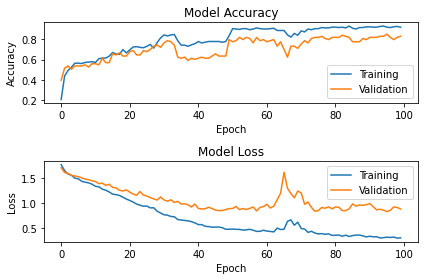

In [ ]:
plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()

plt.show()

save the trained model

In [ ]:
sequence_model = seq_model

In [ ]:
sequence_model.save(folder_root+'saved_model')

INFO:tensorflow:Assets written to: /content/saved_model/assets


INFO:tensorflow:Assets written to: /content/saved_model/assets


load the saved model


In [ ]:
sequence_model = keras.models.load_model(folder_root+'saved_model')

#sequence_model = keras.models.load_model('inceptionv3.tflite')

## Inference code for testing on single video


In [ ]:
import imageio
from tensorflow_docs.vis import embed

def prepare_single_video(path):
       # For each video.
       frames = load_video(path)
       frames = frames[None, ...]
       
       gc.collect()
       # Initialize placeholders to store the masks and features of the current video.
       
       temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
       temp_frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")
       
       # Extract features from the frames of the current video.
       for i, batch in enumerate(frames):
           try:
             video_length = batch.shape[1]
             length = min(MAX_SEQ_LENGTH, video_length)
             for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
             temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked
            #  frame_features = temp_frame_features.squeeze()
            #  frame_masks = temp_frame_mask.squeeze()
           except:
             #print(i, j, length)
             pass
        
       return temp_frame_features, temp_frame_mask

def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(path)
    frame_features, frame_mask = prepare_single_video(path)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]
    
    v = ['call_the_ambulance','i_am_a_student','i_can_not_speak', 'how_are_you', "i_don't_understand", 'extra_class'] # 5 a, 5 b

    for i in np.argsort(probabilities)[::-1]: #Add [::-1][:no] for starting fix number samples
        print(f"  {str(v[class_vocab[i].astype(int)])} :{class_vocab[i]}: {probabilities[i] * 100:5.2f}%")

    
    return frames


def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=25)
    return embed.embed_file("animation.gif")


In [ ]:
test_video = np.random.choice(test_df["path"].values.tolist())
#test_video = '/content/gdrive/MyDrive/sign_videos_sample_a_6/i_can_not_speak/i_can_not_speak-16.mp4'
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
#to_gif(test_frames[:MAX_SEQ_LENGTH])

Test video path: /content/gdrive/MyDrive/sign_videos_sample_a_6/call_the_ambulance/call_the_ambulance-1.mp4
